In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim
import pandas as pd
import torchvision
from torchvision import transforms, utils

from torchvision import models

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
import pickle

In [2]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


### Data preprocessing
We plan to perform transfer learning on EfficentNet-B0 from https://github.com/lukemelas/EfficientNet-PyTorch
<br>
Default input image size was 224 x 224, so we resize CIFAR-10 images.


In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                                            # same normalize as EfficientNet paper
# cifar-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

0it [00:00, ?it/s]

170500096it [00:06, 26540161.19it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Load pretrained model

In [6]:
#! pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=bdc5696c44b1636b60adbfe3101285a02efc3116df1c7485a822875b9d559955
  Stored in directory: /tmp/xdg-cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


In [70]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [71]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [72]:
model._conv_stem.parameters

<bound method Module.parameters of Conv2dStaticSamePadding(
  3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
)>

### Fine tune EfficientNet on CIFAR-10
We change the last fully-connected layer from out 1000 to out 10 as we only have 10 classes.
<br>
The weights for convolutional layers should be freezed so that learned representation is not disturbed.

In [73]:
# change fc output class numbers
model._fc.out_features = 10

# freezing convolutional weights
for param in model._blocks.parameters():
    param.requires_grad = False

In [74]:
# test and return accuracy
def testing(model, testloader, criterion, computing_device):
    # make sure model is in evaluation mode
    model.eval()
    val_loss = 0.0
    val_correct = 0
    test_batch_loss = []
    for data in testloader:
        data, target = data[0].to(computing_device), data[1].to(computing_device)
        output = model(data)
        loss = criterion(output, target)
        
        #test_batch_loss.append(loss)
        val_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_correct += (preds == target).sum().item()
    
    val_loss = val_loss/len(testloader.dataset)
    val_accuracy = 100.0 * val_correct/len(testloader.dataset)
    
    return val_loss, val_accuracy

def training(model, optimizer, trainloader, criterion, computing_device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for data in trainloader:
        data, target = data[0].to(computing_device), data[1].to(computing_device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct/len(trainloader.dataset)
    
    return train_loss, train_accuracy

In [75]:
n_epoch = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

# define optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# bring model to computing device
model = model.to(computing_device)
best_model_weights = copy.deepcopy(model.state_dict()) 

# start training with early stopping
for epoch in range(n_epoch):
    loss,acc = training(model, optimizer, trainloader, criterion, computing_device)
    train_loss.append(loss)
    train_acc.append(acc)
    print("Epoch" + str(epoch) + " : train loss " + str(loss) + ", train accuracy " + str(acc))
    
    loss,acc = testing(model, testloader, criterion, computing_device)
    test_loss.append(loss)
    test_acc.append(acc)
    print("Epoch" + str(epoch) + " : test loss " + str(loss) + ", test accuracy " + str(acc))

    
    ##################early stop####################
    # early stop if validation loss increased
    if(epoch > 5):
        before = test_loss[-2]
        after = test_loss[-1]
        if (before < after and test_acc[-2] > test_acc[-1]):
            break
        else:
            best_model_weights = copy.deepcopy(model.state_dict())
            
model.load_state_dict(best_model_weights)        

Epoch0 : train loss 0.05910572923719883, train accuracy 57.394
Epoch0 : test loss 0.030204515907168387, test accuracy 73.64
Epoch1 : train loss 0.024820131735801696, train accuracy 74.604
Epoch1 : test loss 0.019808607161045075, test accuracy 79.56
Epoch2 : train loss 0.021619242513775824, train accuracy 77.514
Epoch2 : test loss 0.017901834370195865, test accuracy 81.32
Epoch3 : train loss 0.019587102470993996, train accuracy 79.28
Epoch3 : test loss 0.015477605085074902, test accuracy 83.58
Epoch4 : train loss 0.01838693203419447, train accuracy 80.414
Epoch4 : test loss 0.01670953101962805, test accuracy 82.85
Epoch5 : train loss 0.017578474416136743, train accuracy 81.238
Epoch5 : test loss 0.014348875652253628, test accuracy 84.79
Epoch6 : train loss 0.016769017501175404, train accuracy 81.946
Epoch6 : test loss 0.014498740816116334, test accuracy 84.92
Epoch7 : train loss 0.016260885040163993, train accuracy 82.424
Epoch7 : test loss 0.013356045523285866, test accuracy 85.91
Epoc

<All keys matched successfully>

In [41]:
# save fine-tuned model weights
#torch.save(model.state_dict(), 'model/ft_efficient_net_.pth')

### Plots

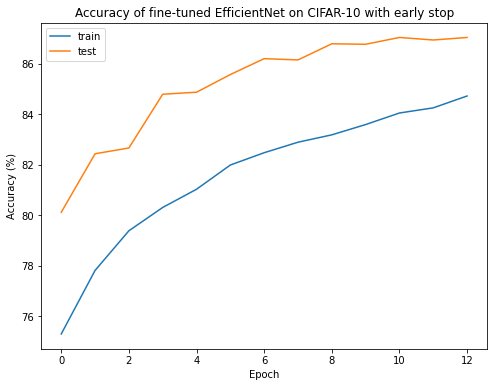

In [53]:
plt.figure(figsize=[8,6])
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of fine-tuned EfficientNet on CIFAR-10 with early stop")

#plt.savefig('plot/accuracy_.png')

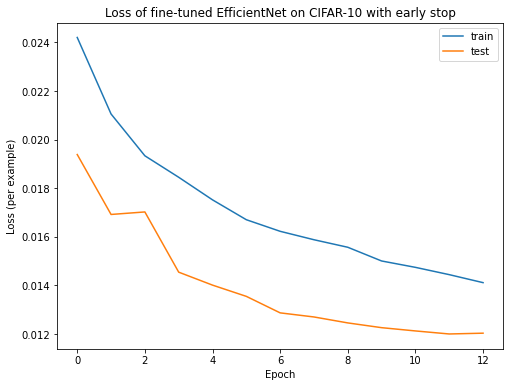

In [54]:
plt.figure(figsize=[8,6])
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss (per example)")
plt.title("Loss of fine-tuned EfficientNet on CIFAR-10 with early stop")

#plt.savefig('plot/loss_.png')